<a href="https://colab.research.google.com/github/NicholasTYD/CS5284_Project/blob/main/CS5284_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
########################################
# Configs
########################################

data_path = "/content/drive/MyDrive/CS Masters/CS5284/Big-Data-Analysis-Master.xlsx"
sheets_for_comparison = ["Raw - By device platform", "Raw - By Age Gender"]

# Modeling controls
test_size = 0.2
seed = 777
min_label_count = 50


## Data Preprocessing

In [ ]:
platform_df = pd.read_excel(data_path, sheet_name=sheets_for_comparison[0])
# age_gender_df = pd.read_excel(data_path, sheet_name=sheets_for_comparison[1])

In [ ]:
def clean_platform_data(df):
  """
  For 'Raw - By device platform' sheet
  - Removes rows with 'unknown' platform or device platform.
  - Removes rows with missing 'Frequency'.
  - Fills missing values in object and numeric columns.
  - Converts 'Amount spent', 'CPM', and 'Cost per Lead' from MYR to SGD.
  - Renames 'CPM (cost per 1,000 impressions)' to 'CPM' and 'Clicks (all)' to 'Clicks'.
  """
  df = df.copy()

  # normalize strings
  for c in ["Platform","Device platform","Currency","Objective","headline","Local Language","Event"]:
      if c in df.columns:
          df[c] = df[c].astype(str).str.strip()

  # remove unknowns
  df = df[df['Platform'] != 'unknown']
  df = df[df['Device platform'] != 'unknown']
  df = df[df['Frequency'].notna()]

  # If na, likely means None
  obj_col = ['Included custom audiences', 'Excluded custom audiences', 'headline']
  for col in obj_col:
    df[col] = df[col].fillna('None')

  num_col = ['Meta leads', 'Cost per Lead', 'Leads', 'Clicks (all)', 'Reach', 'CPM (cost per 1,000 impressions)', 'Amount spent']
  for col in num_col:
    df[col] = df[col].fillna(0)

  for c in ["Reporting starts","Reporting ends"]:
      if c in df.columns:
          df[c] = pd.to_datetime(df[c], errors="coerce")

  # If currency myr, spent/3.2
  mask = df["Currency"].str.upper() == "MYR"
  currency_cols = ['Amount spent', 'CPM (cost per 1,000 impressions)', 'Cost per Lead']
  for col in currency_cols:
      df.loc[mask, col] = df.loc[mask, col].astype(float) / 3.2
  df.loc[mask, "Currency"] = "SGD"

  df.rename(columns={'CPM (cost per 1,000 impressions)': 'CPM', 'Clicks (all)': 'Clicks', 'Cost per Lead': 'CPL'}, inplace=True)

  return df.reset_index(drop=True)

In [ ]:
platform_df = clean_platform_data(platform_df)

In [ ]:
platform_df.head()

,Campaign ID,Ad set ID,Included custom audiences,Excluded custom audiences,Custom Audience Defined,Exclusion Defined,Ad ID,Campaign-Adset-Ad,Ads,Month,...,headline,Local Language,Event,Exclusivity,Rental,Returns,Discounts,Frequency,Reporting starts,Reporting ends
0,23854215253060600,23854219666910600,23848464462960278:Japan Properties submissions...,None,Y,N,23854240034750600,23854215253060600::23854219666910600::23854240...,Seminar Ad – Copy,2023-05-01 - 2023-05-31,...,Limited Slots To Our 10th June Seminar! RSVP Now!,nan,1.0,1.0,NaN,NaN,NaN,2.128540,2023-03-01,2025-03-30
1,120214748420420000,120214749188370000,None,None,N,N,120214755319050000,120214748420420000::120214749188370000::120214...,Image 1,2025-01-01 - 2025-01-31,...,RSVP Now To Find Out More,nan,1.0,NaN,NaN,NaN,NaN,2.612050,2023-03-01,2025-03-30
2,120202424305810000,120202878540600000,"120202620367730205:Lookalike (SG, 4%) - CSI_Bl...",120201965744670205:JLL Canada Waters LF Submit...,Y,Y,120204247231400000,120202424305810000::120202878540600000::120204...,Seminar Image Ad – Copy,2024-01-01 - 2024-01-31,...,RSVP to secure your seat to our FREE seminar o...,nan,1.0,NaN,NaN,NaN,NaN,2.292813,2023-03-01,2025-03-30
3,120210891141630000,120210892492490000,None,None,N,N,120210908829390000,120210891141630000::120210892492490000::120210...,Generic Image Ad – Copy,2024-06-01 - 2024-06-30,...,"Join our exclusive SG launch on July 6th, 2024!",nan,1.0,1.0,NaN,NaN,NaN,2.184487,2023-03-01,2025-03-30
4,23854215253060600,23854220083000600,None,None,N,N,23854240034790600,23854215253060600::23854220083000600::23854240...,Seminar Ad – Copy,2023-05-01 - 2023-05-31,...,Limited Slots To Our 10th June Seminar! RSVP Now!,nan,1.0,1.0,NaN,NaN,NaN,2.067747,2023-03-01,2025-03-30


In [ ]:
platform_df.columns

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends'],
      dtype='object')

In [ ]:
n_rows = len(platform_df)
n_label = int(platform_df["CPL"].notna().sum())
n_positive_leads = int((pd.to_numeric(platform_df.get("Leads", 0), errors="coerce") > 0).sum())

by_platform = platform_df["Platform"].value_counts(dropna=False).head(10)
by_device   = platform_df["Device platform"].value_counts(dropna=False).head(10)

print({
    "rows_total": n_rows,
    "rows_with_Leads_gt0": n_positive_leads,
    "pct_labeled": round(n_label / n_rows, 3) if n_rows else None,
})
print("\nTop Platform counts:\n", by_platform)
print("\nTop Device platform counts:\n", by_device)

{'rows_total': 9617, 'rows_with_Leads_gt0': 1995, 'pct_labeled': 1.0}

Top Platform counts:
 Platform
facebook            5498
instagram           4101
audience_network      14
messenger              4
Name: count, dtype: int64

Top Device platform counts:
 Device platform
mobile_app    8195
mobile_web     763
desktop        659
Name: count, dtype: int64


In [ ]:
# Leakage check
if {"Amount spent","Leads"}.issubset(platform_df.columns):
    leads_pos = platform_df["Leads"].fillna(0) > 0
    check = np.nanmean(
        np.abs((platform_df.loc[leads_pos, "Amount spent"] / platform_df.loc[leads_pos, "Leads"]) - platform_df.loc[leads_pos, "CPL"])
        / (platform_df.loc[leads_pos, "CPL"].replace(0, np.nan).abs())
    )
    print(f"Relative CPL mismatch: {check:.3f}")

Relative CPL mismatch: 0.000


## Feature engineering rationale

Efficiency ratios (CTR, LeadRate, ConvRate, SpendPerImpr)
 - CTR = Clicks/Impressions: creative–audience match; higher CTR usually helps CPL
 - LeadRate = Leads/Impressions (or Reach): direct outcome rate
 - ConvRate = Leads/Clicks: traffic quality
 - SpendPerImpr = AmountSpent/Impressions: local cost of inventory; useful post-launch

Time features from Reporting starts (dow/week/month/year)
 - capture seasonality/drift; use for EDA and chronological split; optional as predictors

Text features from headline (length, word count, has-number)
 - Signals tied to creativity, capturing audiences attention

IF NEEDED:
 - Can consider winsorized in case there are outliers too extreme


In [ ]:
fe_platform_df = platform_df.copy()

num_cols = ["Amount spent","Impressions","Reach","Clicks","Leads","CPM","Frequency"]
for c in num_cols:
    if c in fe_platform_df.columns:
        fe_platform_df[c] = pd.to_numeric(fe_platform_df[c], errors="coerce")

def safe_div(numer, denom):
    """Division that returns NaN when denom is 0/NaN (avoids inf)."""
    a = pd.to_numeric(numer, errors="coerce")
    b = pd.to_numeric(denom, errors="coerce").replace(0, np.nan)
    return a / b

In [ ]:
# Efficiency ratios
# CTR: how engaging is the ad to the audience?
if {"Clicks","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["CTR"] = safe_div(fe_platform_df["Clicks"], fe_platform_df["Impressions"])
elif {"Clicks","Reach"}.issubset(fe_platform_df.columns):
    fe_platform_df["CTR"] = safe_div(fe_platform_df["Clicks"], fe_platform_df["Reach"])

# LeadRate: outcome per delivery
if {"Leads","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["LeadRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Impressions"])
elif {"Leads","Reach"}.issubset(fe_platform_df.columns):
    fe_platform_df["LeadRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Reach"])

# SpendPerImpr: cost pressure (auction/env factor)
if {"Amount spent","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["SpendPerImpr"] = safe_div(fe_platform_df["Amount spent"], fe_platform_df["Impressions"])

# ConvRate: traffic quality after click (Might have leakage here)
if {"Leads","Clicks"}.issubset(fe_platform_df.columns):
    fe_platform_df["ConvRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Clicks"])

## Columns for decision tree
if "Impressions" in fe_platform_df: fe_platform_df["has_impr"]   = (fe_platform_df["Impressions"] > 0).astype(int)
if "Clicks" in fe_platform_df: fe_platform_df["has_clicks"] = (fe_platform_df["Clicks"] > 0).astype(int)
if "Leads" in fe_platform_df: fe_platform_df["has_leads"]  = (fe_platform_df["Leads"]  > 0).astype(int)

fe_platform_df[['CTR','LeadRate','SpendPerImpr','ConvRate','has_impr','has_clicks','has_leads']].head()

,CTR,LeadRate,SpendPerImpr,ConvRate,has_impr,has_clicks,has_leads
0,0.005217,0.001058,0.017028,0.202899,1,1,1
1,0.003756,0.000355,0.008359,0.094444,1,1,1
2,0.010690,0.000407,0.027017,0.038050,1,1,1
3,0.004422,0.000607,0.011898,0.137339,1,1,1
4,0.016832,0.000996,0.013273,0.059160,1,1,1


In [ ]:
# Time features (seasonality & drift)
m = fe_platform_df["Month"].astype(str).str.strip()
# normalize separators (hyphen / en-dash / em-dash) & spaces
m = m.str.replace("[–—]", "-", regex=True)

start_str = m.str.slice(0, 10)
end_str   = m.str.slice(-10)

fe_platform_df["month_start"] = pd.to_datetime(start_str, errors="coerce")
fe_platform_df["month_end"]   = pd.to_datetime(end_str,   errors="coerce")

# derive seasonal features
fe_platform_df["year"]        = fe_platform_df["month_start"].dt.year
fe_platform_df["month"]       = fe_platform_df["month_start"].dt.month
fe_platform_df["quarter"]     = fe_platform_df["month_start"].dt.quarter
fe_platform_df["month_period"]= fe_platform_df["month_start"].dt.to_period("M")

In [ ]:
# Potential Headline features
# Certain text features in headlines can correlate with CTR/ConvRate -> CPL; this is just a simplification of it
s = fe_platform_df["headline"].fillna("None").astype(str)
fe_platform_df["headline_len"]      = s.str.len()
fe_platform_df["headline_words"]    = s.str.split().apply(len).astype("Int64")
fe_platform_df["headline_has_num"]  = s.str.contains(r"\d", regex=True).astype(int)
# keyword cues tied to promos
# promo_terms = ["free","sale","discount","off","%","save","limited","new"]
# for kw in promo_terms:
#     colname = f"headline_kw_{re.sub('[^0-9a-zA-Z]+','_',kw)}"
#     fe_platform_df[colname] = s.str.contains(kw, case=False, regex=True).astype(int)

## EDA: Summary stats

In [ ]:
eda_df = fe_platform_df.copy()

summary = {
    "rows_total": len(eda_df),
    "rows_with_Leads > 0": int((pd.to_numeric(eda_df.get("Leads", 0), errors="coerce")>0).sum()),
    "CPL_min": float(eda_df["CPL"].min(skipna=True)),
    "CPL_median": float(eda_df["CPL"].median(skipna=True)), # Most common CPL, can cause a problem later on - might be worth considering upping the values here abit
    "CPL_mean": float(eda_df["CPL"].mean(skipna=True)),
    "CPL_p95": float(eda_df["CPL"].quantile(0.95)),
}
print("Summary:", summary)

Summary: {'rows_total': 9617, 'rows_with_Leads > 0': 1995, 'CPL_min': 0.0, 'CPL_median': 0.0, 'CPL_mean': 13.105457211866032, 'CPL_p95': 84.43415955849963}


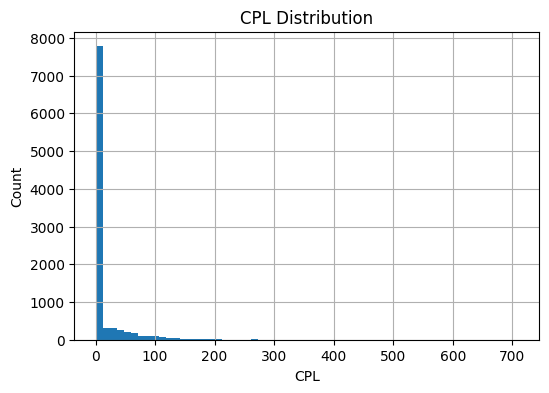

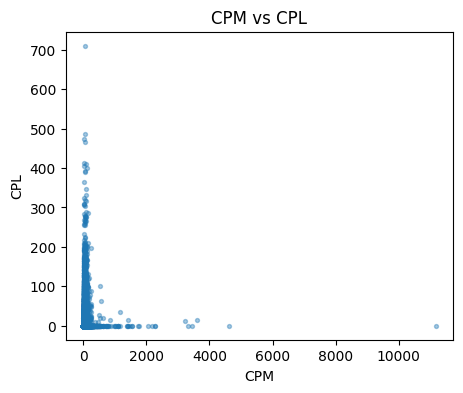

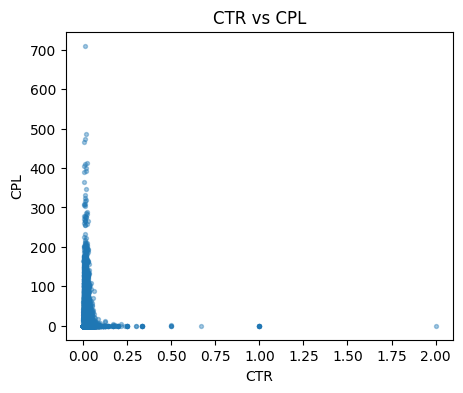

In [ ]:
# CPL histogram
if eda_df["CPL"].notna().sum() > 5:
    plt.figure(figsize=(6,4))
    eda_df["CPL"].dropna().hist(bins=60)
    plt.title("CPL Distribution")
    plt.xlabel("CPL"); plt.ylabel("Count")
    plt.show()

# CPM vs CPL (cost pressure vs outcome)
plt.figure(figsize=(5,4))
plt.scatter(eda_df["CPM"], eda_df["CPL"], s=8, alpha=0.4)
plt.title("CPM vs CPL"); plt.xlabel("CPM"); plt.ylabel("CPL")
plt.show()

# CTR vs CPL (engagement vs outcome)
plt.figure(figsize=(5,4))
plt.scatter(eda_df["CTR"], eda_df["CPL"], s=8, alpha=0.4)
plt.title("CTR vs CPL"); plt.xlabel("CTR"); plt.ylabel("CPL")
plt.show()

In [ ]:
# CPL segment tables (rank by low median & low std)

def segment_table(df, by, min_n=50):
    cols = by + ["CPL"]
    if not set(cols).issubset(df.columns):
        return None
    t = (df.dropna(subset=["CPL"])
           .groupby(by)["CPL"]
           .agg(count="count", mean="mean", median="median", std="std"))
    t = t.assign(cv = t["std"] / (t["mean"].replace(0, np.nan).abs()))
    t = (t.reset_index()
           .query("count >= @min_n")
           .sort_values(["median","std","count"], ascending=[True,True,False]))
    return t

segment_specs = [
    ["Platform"], ["Device platform"], ["Objective"],
    ["Platform","Device platform"]
]

for spec in segment_specs:
    t = segment_table(eda_df, spec, min_n=50)
    if t is not None and len(t):
        print(f"\nTop segments by {spec} (low median CPL, small dispersion):")
        print(t.head(10))



Top segments by ['Platform'] (low median CPL, small dispersion):
    Platform  count       mean  median        std        cv
2  instagram   4101  10.183155     0.0  31.240187  3.067830
1   facebook   5498  15.328131     0.0  41.031092  2.676849

Top segments by ['Device platform'] (low median CPL, small dispersion):
  Device platform  count       mean  median        std        cv
2      mobile_web    763   0.125225     0.0   1.240700  9.907750
0         desktop    659   0.582563     0.0   2.986082  5.125771
1      mobile_app   8195  15.321016     0.0  39.895482  2.603971

Top segments by ['Objective'] (low median CPL, small dispersion):
            Objective  count       mean  median       std        cv
2  OUTCOME_ENGAGEMENT    473   0.000000     0.0   0.00000       NaN
0         LINK_CLICKS     99   0.000000     0.0   0.00000       NaN
3       OUTCOME_LEADS   9040  13.941945     0.0  38.23712  2.742596

Top segments by ['Platform', 'Device platform'] (low median CPL, small dispersion

## EDA Summary (CPL Segments)

Dataset: 9,617 rows, CPL present on all rows but with heavy zero-inflation.

Most segments show median CPL = 0, driven by rows with 0 leads or non-lead objectives. Segments that appear “best” (e.g., mobile_web, desktop) are largely zero-only.

Actionable signal lives in mobile_app (majority of delivery), where mean CPL is non-zero but dispersion is high.

Recommendation for baselines/segments:
 - Recompute effective CPL = Amount spent / Leads; set NaN when Leads==0 (do not record 0) -> See below for amount of data left if feasible to utilise
 - Could utilise gates (e.g., Impressions ≥ 100 and Amount spent ≥ 5) to avoid no-delivery rows.
 - Rank segments by median effective CPL, with dispersion (IQR/std) and measurable coverage (share of rows with Leads>0).
 - Validate stability by month (same ranking holds across time).
 - Things you can utilise if needed: engineered features, leakage-safe feature lists, chronological split policy, and a ready preprocessor (see earlier cells).

In [ ]:
df = eda_df.copy()

df["CPL_eff"] = np.where(
    (pd.to_numeric(df.get("Leads", 0), errors="coerce") > 0) &
    (pd.to_numeric(df.get("Amount spent", 0), errors="coerce") > 0),
    pd.to_numeric(df["Amount spent"], errors="coerce") /
    pd.to_numeric(df["Leads"], errors="coerce"),
    np.nan
)

def segment_table(df, by, min_n=50):
    cols = by + ["CPL_eff"]
    if not set(cols).issubset(df.columns):
        return None
    t = (df.dropna(subset=["CPL_eff"])
           .groupby(by)["CPL_eff"]
           .agg(count="count", mean="mean", median="median", std="std"))
    t = t.assign(cv = t["std"] / (t["mean"].replace(0, np.nan).abs()))
    t = (t.reset_index()
           .query("count >= @min_n")
           .sort_values(["median","std","count"], ascending=[True,True,False]))
    return t

for spec in segment_specs:
    t = segment_table(df, spec, min_n=50)
    if t is not None and len(t):
        print(f"\nTop segments by {spec} (low median CPL, small dispersion):")
        print(t.head(10))


Top segments by ['Platform'] (low median CPL, small dispersion):
    Platform  count       mean     median        std        cv
1  instagram    701  59.573634  44.560000  52.627946  0.883410
0   facebook   1294  65.126788  47.368333  62.543051  0.960328

Top segments by ['Device platform'] (low median CPL, small dispersion):
  Device platform  count       mean   median        std        cv
1      mobile_app   1942  64.652794  47.7625  59.398013  0.918723

Top segments by ['Objective'] (low median CPL, small dispersion):
       Objective  count      mean     median        std        cv
0  OUTCOME_LEADS   1995  63.17553  46.241664  59.294386  0.938566

Top segments by ['Platform', 'Device platform'] (low median CPL, small dispersion):
    Platform Device platform  count       mean  median        std        cv
3  instagram      mobile_app    701  59.573634   44.56  52.627946  0.883410
1   facebook      mobile_app   1241  67.521844   49.72  62.739853  0.929179


In [ ]:
df.columns

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends', 'CTR', 'LeadRate', 'SpendPerImpr', 'ConvRate',
       'has_impr', 'has_clicks', 'has_leads', 'month_start', 'month_end',
       'year', 'month', 'quarter', 'month_period', 'headline_len',
       'headline_words', 'headline_has_num', 'CPL_eff'],
      dtype='object')

In [ ]:
Features_to_utilise = [
    "Platform","Device platform","Objective",
    "Included custom audiences","Excluded custom audiences",
    "Local Language","Event","Exclusivity","Rental","Returns","Discounts",
    "Frequency","headline_len","headline_words","headline_has_num"
] + [c for c in ["month","year"] if c in fe_platform_df.columns]  # for seasonality

# Can consider CTR, SpendPerImpr, CPM

# Obj -> Minimize expected CPL